In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose,LeakyReLU, BatchNormalization, Concatenate
import matplotlib.pyplot as plt
import h5py
import random
import cv2
import os
import keras
from sklearn.model_selection import train_test_split
import math
from pconv_layer import PConv2D


In [63]:
def linear_interpolation(img):
    img_n = cv2.resize(img, (256,256), interpolation = cv2.INTER_NEAREST)
    return img_n

In [64]:
def generate(data_dir):
    lst= []
    for frame in os.listdir(data_dir):
        frame_path= os.path.join(data_dir, frame)
        frame= cv2.imread(frame_path)
        frame= linear_interpolation(frame)
        lst.append(frame)
    return lst

In [65]:
def generate_masks(data_dir):
    lst= []
    for frame in os.listdir(data_dir):
        frame_path= os.path.join(data_dir, frame)
        frame= cv2.imread(frame_path)
        frame= linear_interpolation(frame)
#         frame= np.expand_dims(frame, axis=-1)
        lst.append(frame)
    return lst

In [66]:
input_dir= 'C:\\dataset\\input'
gt_dir= 'C:\\dataset\\gt'
y_dir= 'C:\\dataset\\y'

In [67]:
frames= generate(input_dir)
masks= generate_masks(gt_dir)

In [68]:
outputs= generate(y_dir)

In [76]:
def generate_masked_frames(frames, masks):
    lst= []
    masks_lst=[]
    
    for i in range(len(frames)):
        mask=  cv2.cvtColor(masks[i], cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask , 128, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)

        result = cv2.bitwise_and(frames[i], frames[i], mask=mask_inv)
        lst.append(result)
        masks_lst.append(masks[i])
    
    lst= np.array(lst, dtype='float')
    lst/= 255.0
    
    masks_lst= np.array(masks_lst, dtype='float')
    masks_lst/= 255.0
    
        
    return [lst, masks_lst]

In [108]:
def generate_masked(frame, mask):
    mask=  cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    result = cv2.bitwise_and(frame, frame, mask=mask_inv)
    return result
      

In [109]:
# def generate_batches(frames):
#     batch_size = 8
#     num_frames = len(frames)
#     num_batches = num_frames // batch_size
#     input_frames=[]

#     for batch_index in range(num_batches):
#         start_index = batch_index * batch_size
#         end_index = (batch_index + 1) * batch_size
#         mini_batch = frames[start_index:end_index]
#         input_frames.append(mini_batch)
#     return input_frames

In [110]:
# input_frames= generate_batches(input_frames)
# back= generate_batches(back)

In [124]:
sample_frame= frames[500]
sample_mask= masks[500]
sample_frame= generate_masked(sample_frame, sample_mask)

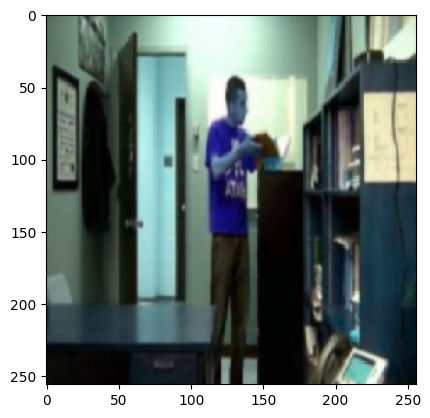

In [125]:
plt.imshow(frames[500])

In [81]:
X_train, X_val, masks_train, masks_val, y_train, y_val= train_test_split(frames, masks, outputs,  test_size=0.2, random_state=42)

In [82]:
X_train= generate_masked_frames(X_train, masks_train)

In [83]:
X_val= generate_masked_frames(X_val, masks_val)

In [85]:

y_train= np.array(y_train, dtype='float')
y_train/=255.0

y_val= np.array(y_val, dtype='float')
y_val/=255.0


In [86]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [91]:
class InpaintingModel:

    def prepare_model(self, input_size=(256,256,3)):
        input_image = keras.layers.Input(input_size)
        input_mask = keras.layers.Input(input_size, name='encoder_input')

        conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
        conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
        conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
        conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

        conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
        conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
        conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
        conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
    def __encoder_layer(self, filters, in_layer, in_mask, names):
        conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
        conv1 = keras.activations.relu(conv1)

        conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
        # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
        conv2 = keras.activations.relu(conv2)

        return conv1, mask1, conv2, mask2

    def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
        up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
        up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
        concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
        concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

        conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
        conv1 = keras.activations.relu(conv1)

        conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
        # conv2 = keras.layers.BatchNormalization()(conv2)
        conv2 = keras.activations.relu(conv2)

        return conv1, mask1, conv2, mask2

In [92]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

In [93]:
with tf.device('/CPU:0'):
    h= model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data= (X_val, y_val))

Epoch 1/20
110/110 [==============================] - 652s 6s/step - loss: 0.2334 - dice_coef: 0.5592 - val_loss: 0.2212 - val_dice_coef: 0.5805
Epoch 2/20
110/110 [==============================] - 635s 6s/step - loss: 0.2196 - dice_coef: 0.6003 - val_loss: 0.2194 - val_dice_coef: 0.5954
Epoch 3/20
110/110 [==============================] - 648s 6s/step - loss: 0.2180 - dice_coef: 0.6042 - val_loss: 0.2184 - val_dice_coef: 0.5968
Epoch 4/20
110/110 [==============================] - 672s 6s/step - loss: 0.2171 - dice_coef: 0.6056 - val_loss: 0.2183 - val_dice_coef: 0.6014
Epoch 5/20
110/110 [==============================] - 676s 6s/step - loss: 0.2166 - dice_coef: 0.6072 - val_loss: 0.2179 - val_dice_coef: 0.6012
Epoch 6/20
110/110 [==============================] - 668s 6s/step - loss: 0.2158 - dice_coef: 0.6072 - val_loss: 0.2167 - val_dice_coef: 0.6053
Epoch 7/20
110/110 [==============================] - 679s 6s/step - loss: 0.2124 - dice_coef: 0.6114 - val_loss: 0.2119 - val_dic

In [126]:
sample_frame= np.array(sample_frame, dtype= 'float')
sample_frame /= 255.0
sample_mask= np.array(sample_mask, dtype= 'float')
sample_mask /= 255.0

In [127]:
sample_frame= [sample_frame]
sample_mask= [sample_mask]
sample_frame= np.array(sample_frame, dtype= 'float')
sample_mask= np.array(sample_mask, dtype= 'float')


In [129]:
pred= model.predict([sample_frame, sample_mask])

1/1 [==============================] - 0s 139ms/step


In [130]:
pred.shape

(1, 256, 256, 3)

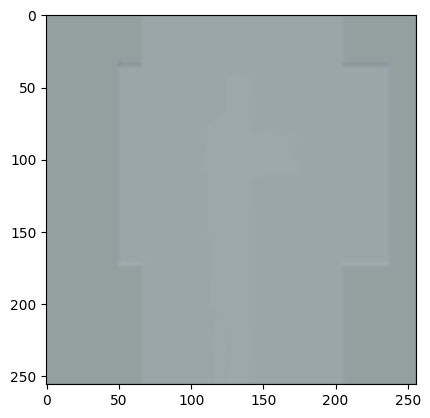

In [131]:
plt.imshow(pred[0])

In [ ]:
input_tensor.shape

In [ ]:
with tf.device('/CPU:0'):
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
    H= model.fit(X_train, y_train, epochs=20, batch_size=8, \
                 validation_data=(X_val, y_val))


In [ ]:
pred= model.predict(input_tensor)

In [ ]:
pred.shape

In [ ]:
tryy = (pred[0][0] * 255).astype(np.uint8)

In [ ]:
# pred

In [ ]:
plt.imshow(tryy)

In [ ]:
plt.imshow(input_tensor[0][0])

In [ ]:
model.save('weights.h5')